In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
db = pd.read_csv("diabetes_dataset.csv")

In [3]:
db.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [4]:
db.shape

(1000, 14)

In [5]:
db['CLASS'].unique()

array(['N', 'N ', 'P', 'Y', 'Y '], dtype=object)

In [3]:
db['CLASS'] = db['CLASS'].str.strip()
db['CLASS'].unique()

array(['N', 'P', 'Y'], dtype=object)

In [7]:
db['Gender'].unique()

array(['F', 'M', 'f'], dtype=object)

In [4]:
db['Gender'] = db['Gender'].str.upper()
db['Gender'].unique()

array(['F', 'M'], dtype=object)

In [ ]:
db.describe()

In [5]:
db['Gender'] = db['Gender'].map({'M': 0, 'F': 1})

In [6]:
X = db.drop("CLASS", axis=1)  # 'class' is the target column
X.drop("No_Pation", axis=1)
X.drop("ID", axis=1)
y = db["CLASS"].map({'N': 0, 'P': 1, 'Y': 1})  # assuming binary labels

Decision Tree:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       1.00      0.99      0.99       264

    accuracy                           0.99       300
   macro avg       0.97      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



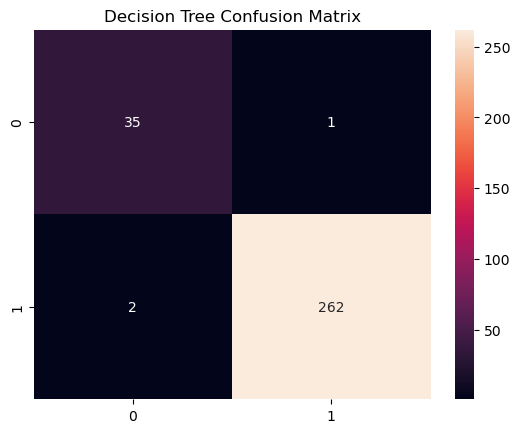

In [7]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 1. Decision Tree ---
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_test)

print("Decision Tree:")
print(classification_report(y_test, tree_preds))
sns.heatmap(confusion_matrix(y_test, tree_preds), annot=True, fmt='d')
plt.title("Decision Tree Confusion Matrix")
plt.show()

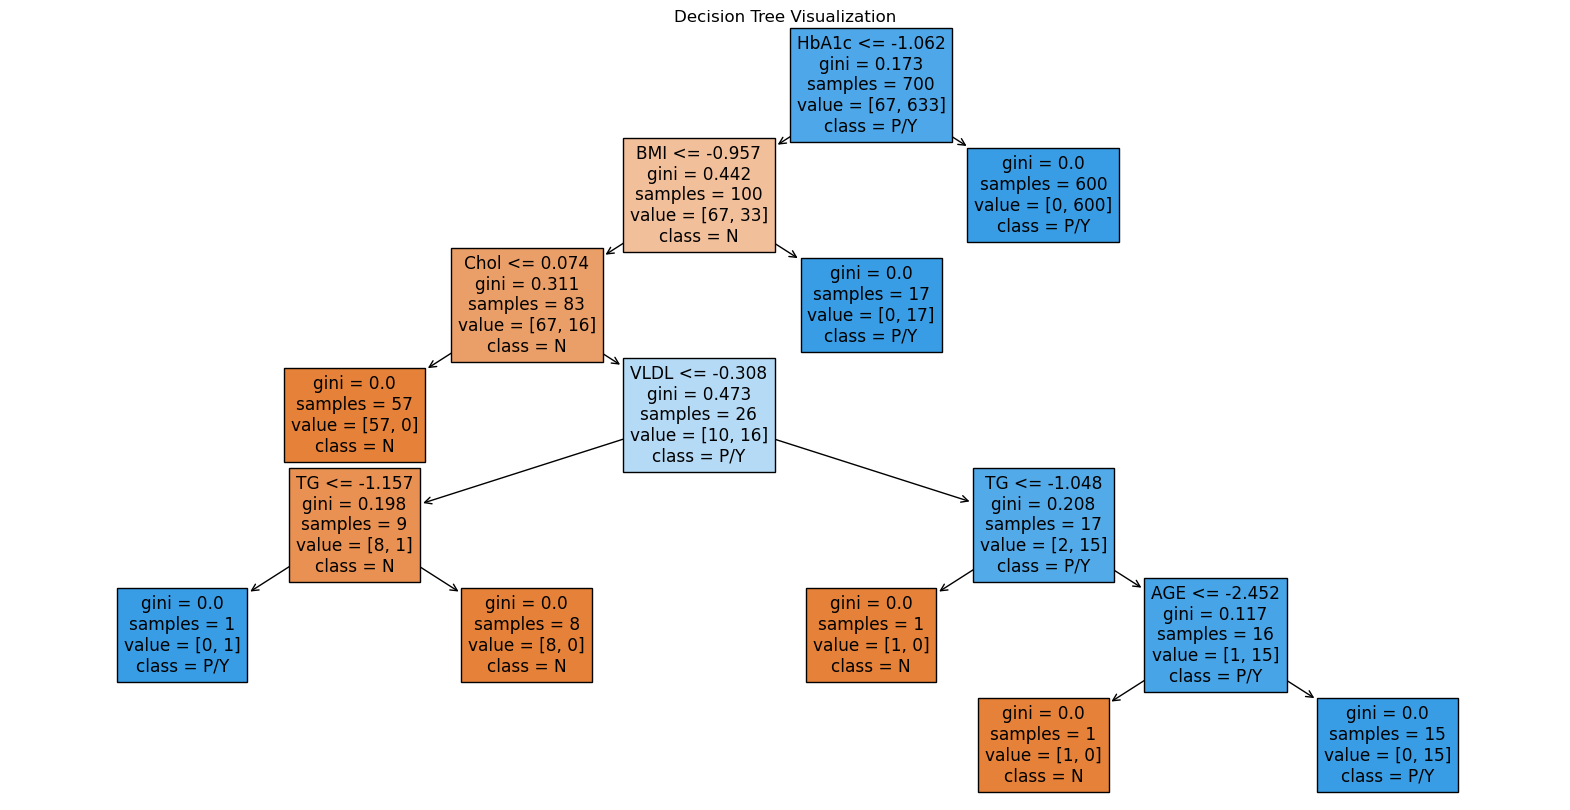

In [11]:
plt.figure(figsize=(20,10))
tree.plot_tree(tree_model, feature_names=list(X.columns), class_names=['N', 'P/Y'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()
